# Experiment 3: Random Forest (Baseline)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 0: Setup Environment

In [ ]:

# Install required libraries
!pip install aif360 shap scikit-learn pandas matplotlib seaborn --quiet

# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import matplotlib.pyplot as plt

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.9 MB/s eta 0:00:00


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


## Step 1: Load and Preprocess LendingClub Dataset

In [ ]:

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')  # Updated path

# Select relevant columns
selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna()

# Convert target to binary
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Encode categorical features
for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Normalize income
df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])


/tmp/ipython-input-3097079003.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')  # Updated path


## Step 2: Create AIF360 Dataset

In [ ]:

# Define privileged and unprivileged groups (e.g., zip_code as proxy)
privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

# Create AIF360 dataset
aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])


## Step 3: Train Random Forest Classifier

In [ ]:

# Extract features and labels
X = aif_data.features
y = aif_data.labels.ravel()

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Predict
y_pred = clf.predict(X)
y_prob = clf.predict_proba(X)[:, 1]


## Step 4: Evaluate Performance and Fairness

In [ ]:

# Performance metrics
print("Accuracy:", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1 Score:", f1_score(y, y_pred))
print("AUC-ROC:", roc_auc_score(y, y_prob))

# Fairness metrics
pred_dataset = aif_data.copy()
pred_dataset.labels = y_pred.reshape(-1, 1)

metric = ClassificationMetric(aif_data, pred_dataset,
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact:", metric.disparate_impact())
print("Equal Opportunity Difference:", metric.equal_opportunity_difference())
print("Average Odds Difference:", metric.average_odds_difference())
print("Bias Amplification:", metric.between_group_generalized_entropy_index())
print("Theil Index:", metric.theil_index())


Accuracy: 0.9994
Precision: 0.9997249724972497
Recall: 0.9994500962331592
F1 Score: 0.9995875154681699
AUC-ROC: 0.9999986887841216
Statistical Parity Difference: 0.42307692307692313
Disparate Impact: 1.8461538461538463
Equal Opportunity Difference: 0.0
Average Odds Difference: 0.0
Bias Amplification: 166.16666666666666
Theil Index: 0.000477334337758019


## Step 5: SHAP Explainability (Global & Subgroup)

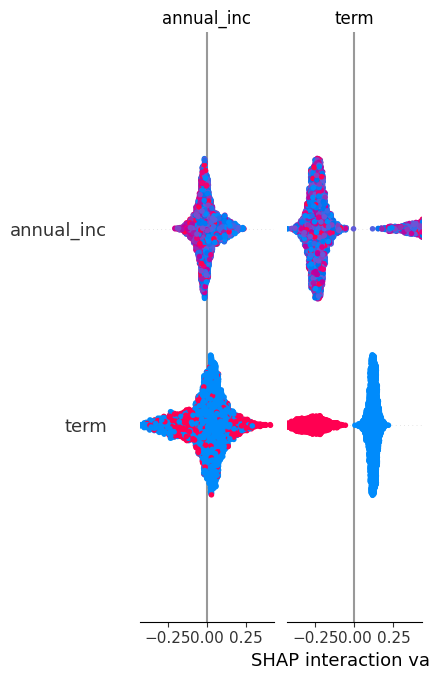

In [ ]:

# SHAP analysis
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# Global summary plot
X_df = pd.DataFrame(X, columns=aif_data.feature_names)
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_df)

    # Subgroup analysis
    privileged_mask = X_df['zip_code'] == 1
    unprivileged_mask = X_df['zip_code'] == 0

    print("SHAP Summary for Privileged Group:")
    shap.summary_plot(shap_values[1][privileged_mask], X_df[privileged_mask])

    print("SHAP Summary for Unprivileged Group:")
    shap.summary_plot(shap_values[1][unprivileged_mask], X_df[unprivileged_mask])
else:
    shap.summary_plot(shap_values, X_df)


## Optional: Save Results

In [ ]:

results = {
    'Accuracy': accuracy_score(y, y_pred),
    'Precision': precision_score(y, y_pred),
    'Recall': recall_score(y, y_pred),
    'F1': f1_score(y, y_pred),
    'AUC': roc_auc_score(y, y_prob),
    'SPD': metric.statistical_parity_difference(),
    'DI': metric.disparate_impact(),
    'EOD': metric.equal_opportunity_difference(),
    'AOD': metric.average_odds_difference(),
    'BiasAmp': metric.between_group_generalized_entropy_index(),
    'Theil': metric.theil_index()
}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/Research_Thesis_Implementation/exp3_rf_baseline_results.csv', index=False)
